# Tester notebook for RCC

In [152]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from sklearn.metrics import silhouette_score

from models.radially_constrained_cluster import *
from models.X_RCC import XRCC, XRCC_silscore
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_0')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [3]:
dataset_t2m = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/2m_temperature/temperature_*.nc').var167.load()
dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_*.nc').tp.load()

In [4]:
dataset_tp['time'] = dataset_t2m['time']

In [5]:
datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

clustering_params = {
    'iters': 20,
    'n_seas': 2,
    'learning_rate': 10,
    'min_len': 30,
    'mode': 'single',
    'starting_bp': [165, 264],
}

result = XRCC(datasets, **clustering_params)

/work/users/jgrassi/RCC_fin/src/models/X_RCC.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


In [6]:
import datetime
def get_ordinal_suffix(day):
    if 10 <= day <= 20:
        return 'th'
    else:
        last_digit = day % 10
        if last_digit == 1:
            return 'st'
        elif last_digit == 2:
            return 'nd'
        elif last_digit == 3:
            return 'rd'
        else:
            return 'th'
        
def day_of_year_to_date(day_of_year, year=None):
    if year is None:
        year = datetime.datetime.now().year
    
    try:
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)
        day = date.day
        month = date.strftime("%b")
        ordinal_suffix = get_ordinal_suffix(day)
        return fr"{month} {day}{ordinal_suffix}"
    except ValueError:
        return "Invalid day of the year"

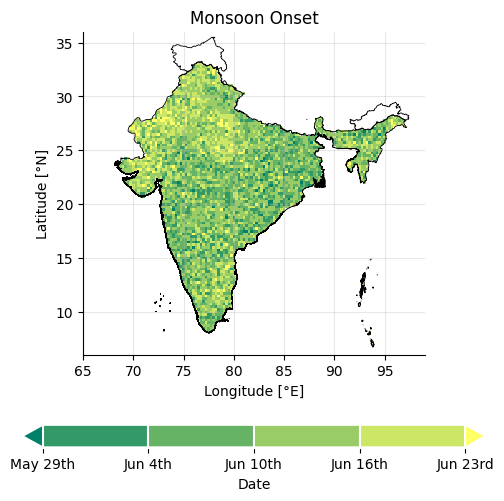

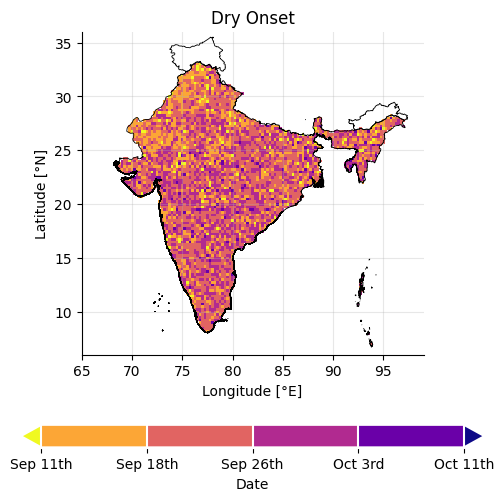

In [7]:
for j,title,cmap,s in zip(range(2),['Monsoon Onset', 'Dry Onset'],['summer','plasma_r','cividis','magma_r'],[[150,175], [255,285]]):
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))

    to_plt = result.sel(cluster=j)
    lev = np.linspace(s[0],s[1],5)

    cont_1 = to_plt.plot(levels=lev, extend='both',ax=ax, add_colorbar=False, cmap=cmap)
    country_boundary.boundary.plot(color = 'k', linewidth = 0.6, label = 'Regioni', ax=ax)
    # Customize the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # List of neighboring countries to include in the map
    # states = ['FRA','CHE', 'HRV','SVN','BIH']
    # world.boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
    # world.plot(color='gray', alpha=0.3, ax=ax)

    # # Plot boundaries for each neighboring country
    # for state in states:
    # #    world[world.GID_0 == state].boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
    #     world[world.GID_0 == state].plot(color='gray', alpha=0.3, ax=ax)

    ax.set_xlim(65, 99)
    ax.set_ylim(6, 36)


    cbar = plt.colorbar(cont_1, orientation='horizontal', drawedges=True)
    cbar.set_ticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev])

    cbar.outline.set_color('white')
    cbar.outline.set_linewidth(2)
    cbar.dividers.set_color('white')
    cbar.dividers.set_linewidth(1.5)

    cbar.set_label('Date')

In [53]:
def X_silhouette(*grid_points, **kwargs):
    """
    Perform clustering on multiple variables from grid points.

    Parameters:
    -----------
    *grid_points : tuple of numpy arrays
        Input grid points variables to be clustered.
    **kwargs : keyword arguments
        Additional parameters for clustering.

    Returns:
    --------
    np.ndarray
        Array of breakpoints from clustering.
    """
    iters = kwargs.get('iters', 20)  
    n_seas = kwargs.get('n_seas', 2)
    learning_rate = kwargs.get('learning_rate', 10)
    min_len = kwargs.get('min_len', 30)
    mode = kwargs.get('mode', 'single')
    starting_bp = kwargs.get('starting_bp', [165, 264])

    arrays = []
    
    for grid_points_var in grid_points:
        grid_points_var = np.asarray(grid_points_var)
        grid_points_var = np.reshape(grid_points_var, (365, 32), order='F')
        
        if np.isnan(grid_points_var).any():
            return np.full(n_seas, np.nan)
        
        arrays.append(grid_points_var)
    
    combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)
    
    normalized_arrays = []
    for arr in arrays:
        array_tot = arr[:, combined_mask]
        array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)
        normalized_arrays.append(array_tot)
    
    array_tot = np.concatenate(normalized_arrays, axis=1)

    # Initialize and fit the Radially_Constrained_Cluster model
    model = Radially_Constrained_Cluster(data_to_cluster=array_tot,
                                         n_seas=n_seas,
                                         n_iter=iters,
                                         learning_rate=learning_rate,
                                         min_len=min_len,
                                         mode=mode,
                                         starting_bp=starting_bp)
    
    model.fit()
    silhouette = silhouette_score(array_tot, model.get_prediction())

    return silhouette


def XRCC_silscore(datasets, **kwargs):
    """
    Apply clustering function to a list of xarray DataArrays.

    Parameters:
    -----------
    datasets : list of xarray DataArrays
        Input datasets to be clustered.
    **kwargs : keyword arguments
        Additional parameters for clustering.

    Returns:
    --------
    xarray.DataArray
        Result of clustering operation.
    """
    result = xr.apply_ufunc(
        X_silhouette,
        *datasets,
        kwargs=kwargs,
        input_core_dims=[['time']] * len(datasets),
        output_core_dims=[['n_seasons']],
        vectorize=True,
        output_sizes={'n_seasons': 1},
        dask='parallelized',
        output_dtypes=[float]
    )

    return result

In [128]:
datasets = [dataset_t2m, dataset_tp]  # List of xarray DataArrays

tot = []
for j, st in zip([2,4], [[165, 264],[80, 165, 264, 300]]):
    clustering_params = {
        'iters': 30,
        'learning_rate': 10,
        'min_len': 30,
        'mode': 'single',
        'starting_bp': st,  # Optional, if starting_bp is used
        'n_seas' : j
    }

    silhouette_scores = XRCC_silscore(datasets, **clustering_params).sel(n_seasons=0)
    tot.append(silhouette_scores.assign_coords(n_seasons=j))

In [129]:
tota = xr.concat(tot, dim='n_seasons')

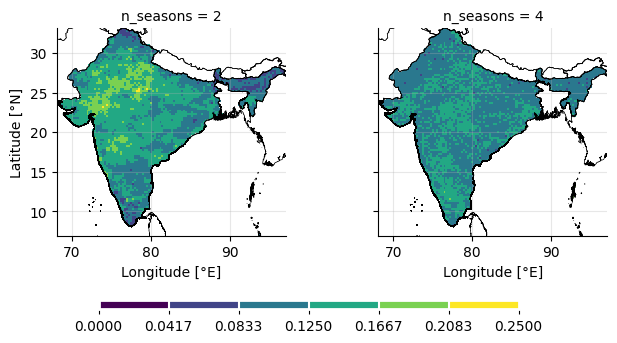

In [174]:
plot = tota.plot(col='n_seasons', col_wrap=2, vmin=0, vmax=0.25, levels=7, add_colorbar=False, figsize=(7,3))

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

In [131]:
combined_data_array_filled = tota.fillna(-np.inf)
max_n_seasons_idx = combined_data_array_filled.argmax(dim='n_seasons')
max_n_seasons = tota['n_seasons'][max_n_seasons_idx]

# Crea un mask per individuare dove entrambi i n_seasons sono NaN
nan_mask = np.isnan(tota.sel(n_seasons=2)) & np.isnan(tota.sel(n_seasons=4))

# Rimuovere i NaN dai risultati finali usando il mask
max_n_seasons = max_n_seasons.where(~nan_mask)

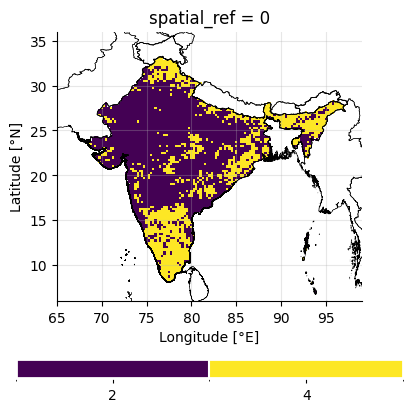

In [172]:
plot = max_n_seasons.plot(vmin=1, vmax=5, levels=3, add_colorbar=False, figsize=(5,5))

standard_format_single( plot,
                        country_boundary   = country_boundary,
                        world_boundary     = world_boundary,
                        custom_cbar        = True
                        )
plot.colorbar.set_ticks(ticks=[2,4], labels=[2,4])